# Straight-ray tomography

In the following notebook, we perform a simple straight-ray tomography in 2D. This serves to illustrate some of the basic concept of linear least-squares inversion, such as prior and posterior covariances, damping, smoothing, over- and under-fitting, and resolution.

# 0. Import some Python packages

We begin by importing some Python packages for matrix-vector operations, for plotting, and for computing the forward modelling matrix $\mathbf{G}$.

In [1]:
# Some Python packages.

import numpy as np
import scipy
import time

import sys
sys.path.insert(0,'./utils')  # This contains functions to compute G.
from grid import *
from straight_ray_tracer import *

# Set some parameters to make plots nicer.

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})

# 1. Basic input

In the following few lines, we define the most basic geometric input, including the dimensions of the model domain, as well as the positions of sources and receivers. The initial setup mimics a cross-hole tomography where sources are on one side of the domain, and receivers are on the other one.

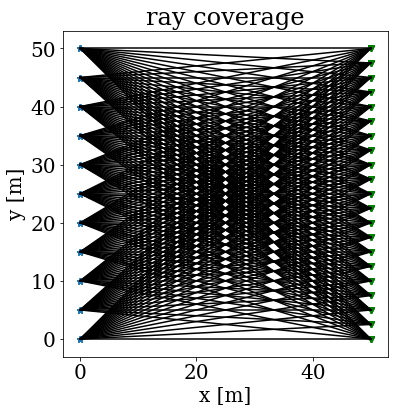

In [2]:
# Define the numerical grid. ---------------------------------------------
dimension=2 # Here we only consider 2D problems anyway.
x_min=0.0 # Minimum x-coordinate  
y_min=0.0 # Minimum y-coordinate
dx=2.5 # Grid spacing in x-direction
dy=2.5 # Grid spacing in y-direction
Nx=20.0 # Number of grid points in x-direction
Ny=20.0 # Number of grid points in y-direction
g = grid(dimension, [x_min,y_min], [dx,dy], np.array([Nx,Ny]))

# Sources and receivers. -------------------------------------------------
src_locations = np.array([ 0.0 * np.ones((11,)), np.linspace(0,50,11)])
rec_locations = np.array([ 50.0 * np.ones((21,)), np.linspace(0,50,21)])

sources, receivers = get_all_to_all_locations(src_locations, rec_locations)
plot_rays(sources, receivers, g)

# 2. Compute forward matrix G

Knowing source and receiver positions, and the setup of the domain, we can compute the forward modelling matrix **G** that connects a slowness model **m** to a synthetic data vector **d** via **d**=**Gm**. In addition to computing **G**, we also visualise the ray density and the entries of **G**. We will see that ray density is rather uneven, and that **G** is pretty sparse.

Time elapsed:          0.0181 s
Matrix shape:             (231, 400)
Data points:              231
Unknowns in model space:  400
Non-zero entries:         5625
Ratio of non-zeros:     6.0877 %


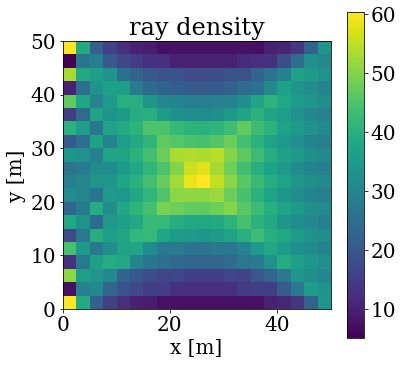

Sparsity pattern of the forward matrix:


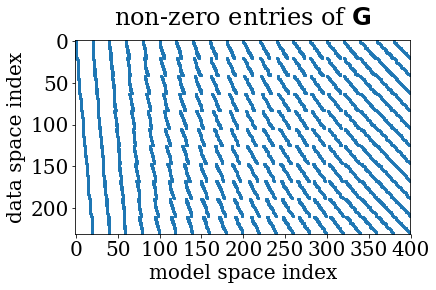

In [3]:
# Compute G and measure how long that takes.
tic = time.clock()
G = create_forward_operator(sources, receivers, g)
toc = time.clock()

# Print some statistics of G.
print('Time elapsed:      {:10.4f} s'.format(toc-tic))
print('Matrix shape:            ', G.shape)
print('Data points:             ', G.shape[0])
print('Unknowns in model space: ', G.shape[1])
print('Non-zero entries:        ', G.count_nonzero())
print('Ratio of non-zeros: {:10.4f} %'.format(100 * G.count_nonzero() / (G.shape[0] * G.shape[1])))

# Plot ray density and entries of G.
plot_ray_density(G,g)

print('Sparsity pattern of the forward matrix:')
plt.spy(G, markersize=2)
plt.gca().xaxis.tick_bottom()
plt.xlabel('model space index')
plt.ylabel('data space index')
plt.title(r'non-zero entries of $\mathbf{G}$')
plt.show()

# 3. Create target model

Since we work with artifical and not with real traveltime data, we need to define a target model that we wish to reconstruct. In the basic setup, our target model is a simple chequerboard pattern of slowness values.

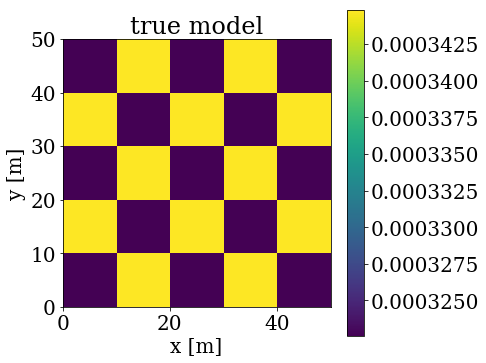

In [4]:
# Input model setup (chequerboard). --------------------------------------
dvp = 100.0   # velcity variations in m/s.
dd = 4        # Width of the chequerboard cells in number of cells.

# Allocate velocity matrix. Homogeneous background model.
vp = 3000.0 * np.ones(g.npoints) 

# Add some heterogeneities
s = 1.0
for i in range(0,g.npoints[0],dd):    

    for j in range(0,g.npoints[1],dd):    
        end_i = min(g.npoints[0],i+dd)
        end_j = min(g.npoints[1],j+dd)
        vp[i:end_i,j:end_j] += s*dvp
        s *= -1
        
m_true = (1/vp).ravel()

clim = [1/3100, 1/2900]
plot_model(m_true, g, 'true model', caxis=clim)

# 4. Generate synthetic measurements

Having defined the target model, it remains to compute artificial traveltime data that enter the observed data vector $\mathbf{d}^\text{obs}$. To be more realistic, we add random errors to the traveltime data. The amplitude of these errors are defined by the parameter *sigma_d*. Knowing *sigma_d*, we then compute the prior data covariance $\mathbf{C}_D$. 

In the real world, measurement errors will usually not do us the favour of being nicely normally distributed. Even if they were, it could be difficult to estimate the correct prior data covariance.

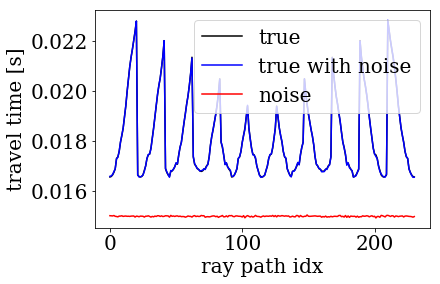

In [14]:
# Create observed data ---------------------------------------------------
d_true = G * m_true

# Prior covariance parameters. -------------------------------------------
sigma_d  = 0.2e-4         # Data standard deviation.
d_obs = d_true + sigma_d * np.random.randn(len(d_true))

# Data covariance matrix. ------------------------------------------------
Cd = sigma_d**2 * scipy.sparse.eye(len(d_obs))
Cd_inv = 1 / sigma_d**2 * scipy.sparse.eye(len(d_obs))


plt.plot(d_true, 'k', label='true')
plt.plot(d_obs, 'b', label='true with noise')
plt.plot(0.015 + (d_obs-d_true), 'r', label='noise')
plt.legend()
plt.ylabel('travel time [s]')
plt.xlabel('ray path idx')
plt.show()

# 5. Compute prior model covariance

The final step before solving the inverse problem is to define the prior mean model $\mathbf{m}^\text{prior}$, and the prior covariance in model space, $\mathbf{C}_M$. For the latter, we need to define the correlation length, contained in the parameter *corr_len*. To visualise the effect of $\mathbf{C}_M$, we can plot its action on the target model. 

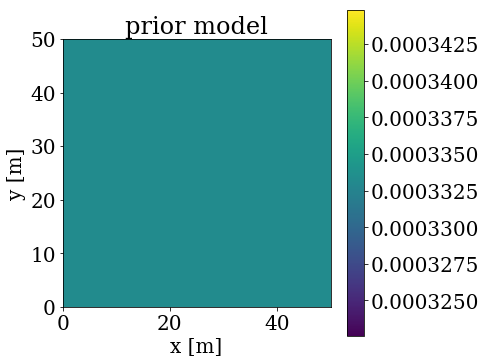

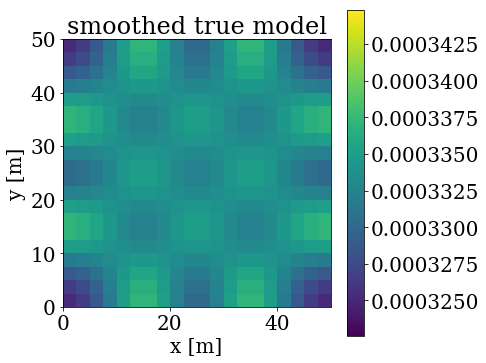

In [15]:
# Prior model. -----------------------------------------------------------
m_prior = np.ones(m_true.shape) / 3000.0

# Prior covariance. ------------------------------------------------------
corr_len = 5.0
regularization_weight = 1e-9

Cm = g.get_gaussian_prior(corr_len)

plot_model(m_prior, g, 'prior model', caxis=clim)
plot_model(Cm*m_true, g, 'smoothed true model', caxis=clim)

Cm *= regularization_weight
Cm_inv = scipy.sparse.linalg.inv(Cm)

# 6. Solve inverse problem

We are now equipped with all ingredients needed to solve the inverse problem. For this, we need to compute the inverse of the Hessian of the least-squares misfit functional, $\mathbf{C}_M^{-1}+\mathbf{G}^T \mathbf{C}_D^{-1} \mathbf{G}$, which is equal to the posterior covariance, $\mathbf{\tilde{C}}_M$.

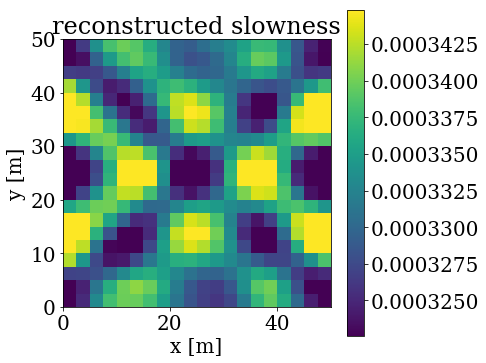

In [17]:
# Hessian ----------------------------------------------------------------
H = G.T * Cd_inv * G + Cm_inv

# Posterior covariance ---------------------------------------------------
Cm_post = scipy.sparse.linalg.inv(H);

# Posterior mean. --------------------------------------------------------
m_est = Cm_post * (G.T * Cd_inv * d_obs + Cm_inv * m_prior)
d_est = G * m_est
d_prior = G * m_prior

# Plot. ------------------------------------------------------------------
plot_model(m_est, g, 'reconstructed slowness', caxis=clim)


# 7. Exercises

**Exercise 1**: Plot the difference between (artificial) observed data and data estimated from the posterior mean model. Are the observations explained to within their uncertainties? Are the data over- or under-fit?

**Exercise 2**: Plot the posterior covariance for a model parameter near the centre and a model parameter near the edge of the domain. How do the posterior variances and covariances compare? Is the result in accord with your intuitive expectations based on the ray coverage plot?

**Exercise 3**: Compute and plot an L-curve for the smoothing parameter (correlation length). Choose an optimal smoothing based on the L-curve.

**Exercise 4**: Compute and visualise the resolution matix.